In [33]:
!pip install gdown

In [34]:
import gdown
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


file_id = '1S4N_Xa8bQMaQ-fNC2zbJb3SquXF6czc5'
url = f'https://drive.google.com/uc?id={file_id}'
output = 'META.csv'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1S4N_Xa8bQMaQ-fNC2zbJb3SquXF6czc5
To: /content/META.csv
100%|██████████| 56.6k/56.6k [00:00<00:00, 44.6MB/s]


'META.csv'

In [35]:
# Load the dataset
data = pd.read_csv(output)

# Sort the data by date
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values('Date', inplace=True)

# Select the 'Open' and 'Close' columns
data = data[['Date', 'Open', 'Close']]

# Convert the dataframe to a numpy array
dataset = data[['Open', 'Close']].values

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Split the data into training and testing sets
training_data_len = int(np.ceil(len(dataset) * .8))

train_data = scaled_data[0:int(training_data_len), :]
test_data = scaled_data[int(training_data_len) - 60:, :]

# Create the training data set
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i])
    y_train.append(train_data[i])

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [36]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dense(units=80))
model.add(Dense(units=2))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [37]:
# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=10)

Epoch 1/10
544/544 [==============================] - 13s 15ms/step - loss: 0.0030
Epoch 2/10
544/544 [==============================] - 8s 14ms/step - loss: 0.0011
Epoch 3/10
544/544 [==============================] - 5s 9ms/step - loss: 0.0010
Epoch 4/10
544/544 [==============================] - 4s 7ms/step - loss: 7.0595e-04
Epoch 5/10
544/544 [==============================] - 4s 7ms/step - loss: 6.9048e-04
Epoch 6/10
544/544 [==============================] - 5s 9ms/step - loss: 6.5128e-04
Epoch 7/10
544/544 [==============================] - 4s 8ms/step - loss: 5.3320e-04
Epoch 8/10
544/544 [==============================] - 4s 8ms/step - loss: 4.8111e-04
Epoch 9/10
544/544 [==============================] - 5s 9ms/step - loss: 4.4707e-04
Epoch 10/10
544/544 [==============================] - 4s 8ms/step - loss: 4.7182e-04


In [38]:
# Create the testing data set
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Get the model's predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print('RMSE:', rmse)

5/5 [==============================] - 1s 4ms/step
RMSE: 11.428477698993163


<ipython-input-39-312d4e04e6b4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions_Open'] = predictions[:, 0]
<ipython-input-39-312d4e04e6b4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions_Close'] = predictions[:, 1]


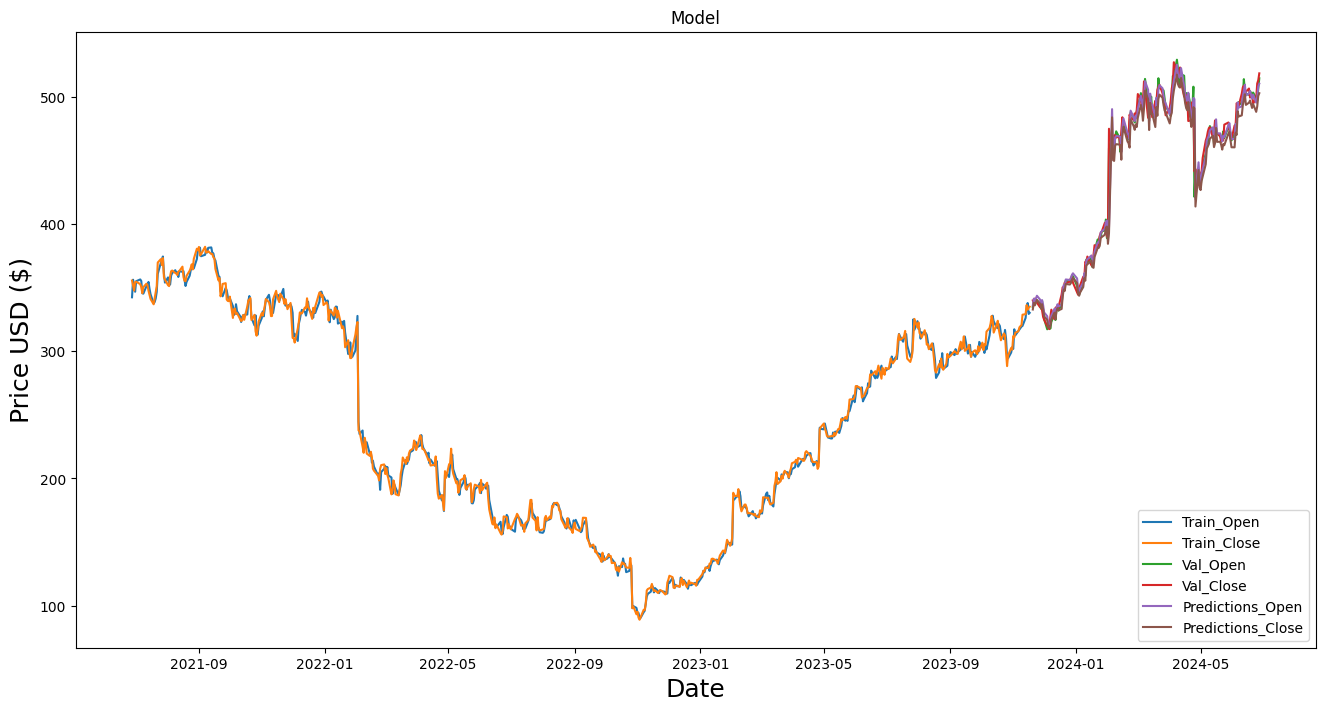

In [39]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions_Open'] = predictions[:, 0]
valid['Predictions_Close'] = predictions[:, 1]

# Visualize the data
plt.figure(figsize=(16, 8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price USD ($)', fontsize=18)
plt.plot(train['Date'], train[['Open', 'Close']])
plt.plot(valid['Date'], valid[['Open', 'Close']])
plt.plot(valid['Date'], valid[['Predictions_Open', 'Predictions_Close']])
plt.legend(['Train_Open', 'Train_Close', 'Val_Open', 'Val_Close', 'Predictions_Open', 'Predictions_Close'], loc='lower right')
plt.show()

In [40]:
# Predicting the stock price for June 28, 2024
last_60_days = scaled_data[-60:]
X_test = []
X_test.append(last_60_days)
X_test = np.array(X_test)

pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
print('Predicted Open Price for June 28, 2024:', pred_price[0][0])
print('Predicted Close Price for June 28, 2024:', pred_price[0][1])

1/1 [==============================] - 0s 20ms/step
Predicted Open Price for June 28, 2024: 516.89825
Predicted Close Price for June 28, 2024: 509.24362
